In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
import random
import re
from src.functions import *
import random
import datetime
from src.simple_TF_continuos import *

import absl.logging #prevent checkpoint warnings while training

absl.logging.set_verbosity(absl.logging.ERROR)

%load_ext autoreload
%autoreload 2


# import seaborn as sns
# import warnings; warnings.filterwarnings(action='once')
# large = 22; med = 16; small = 12
# params = {'axes.titlesize': large,
#           'legend.fontsize': med,
#           'figure.figsize': (16, 10),
#           'axes.labelsize': med,
#           'axes.titlesize': med,
#           'xtick.labelsize': med,
#           'ytick.labelsize': med,
#           'figure.titlesize': large}
# plt.rcParams.update(params)
# plt.style.use('seaborn-whitegrid')
# sns.set_style("white")

%matplotlib inline
%config InlineBackend.figure_format = 'png'

2022-03-16 17:15:50.041868: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [135]:
# model_path = "/home/tum/data/models/TF_augmented_data/"
# model_name = "TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:4&dropout_rate:0.1&wp_d:2.h5"
# model_path = "/home/tum/data/models/test_refine/"
# model_name = "refined_TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:4&dropout_rate:0.1&wp_d:2.h5"


# model_path = "/home/tum/data/models/exp_depth_refining/"
# model_name = "TF&num_layers_enc:1&num_layers_dec:6&d_model:256&dff:1024&num_heads:8&dropout_rate:0.1&wp_d:2&bs:64&dense_n:512&num_dense:5&concat_emb:True&features_n:777.h5"
# model_path = "/home/tum/data/models/exp_norm_layer/"
# model_name = "TF&num_layers_enc:1&num_layers_dec:4&d_model:256&dff:512&num_heads:8&dropout_rate:0.1&wp_d:2&bs:64&dense_n:512&num_dense:3&concat_emb:True&features_n:777&optimizer:adam&norm_layer:True.h5"
# model_path = "/home/tum/data/models/exp_norm_layer_tanh_warmup/"
# model_name = "refined_TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:8&dropout_rate:0.1&wp_d:2&bs:64&dense_n:512&num_dense:3&concat_emb:True&features_n:777&optimizer:adam&norm_layer:True&activation:tanh.h5"
model_path = "./models/"
model_name = "refined_refined_TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:8&dropout_rate:0.1&wp_d:2&bs:64&dense_n:512&num_dense:3&concat_emb:True&features_n:777&optimizer:RMSprop&norm_layer:True&activation:tanh.h5"

model_file = model_path+model_name
model = load_model(model_file)
compile(model)

{'num_layers_enc': 2, 'num_layers_dec': 4, 'd_model': 256, 'dff': 512, 'num_heads': 8, 'dropout_rate': 0.1, 'wp_d': 2, 'bs': 64, 'dense_n': 512, 'num_dense': 3, 'concat_emb': True, 'features_n': 777, 'optimizer': 'RMSprop', 'norm_layer': True, 'activation': 'tanh'}
loading weights:  /home/tum/data/models/exp_optmizer_depth/refined_refined_TF&num_layers_enc:2&num_layers_dec:4&d_model:256&dff:512&num_heads:8&dropout_rate:0.1&wp_d:2&bs:64&dense_n:512&num_dense:3&concat_emb:True&features_n:777&optimizer:RMSprop&norm_layer:True&activation:tanh.h5


In [3]:
from src.motion_refiner import Motion_refiner

traj_n = 10
mr = Motion_refiner(traj_n = traj_n)

## ------- processed data -------
# X,Y = mr.prepare_data(data,deltas=True)
# print("X: ",X.shape)
# print("Y: ",Y.shape)

## ------- save pre processed data -------
# mr.save_XY(X, Y, x_name="X_delta_new_names",y_name="Y_delta_new_names")
# mr.save_data(data,data_name="data_delta_new_names")

# ------- load data --------
X_, Y_ = mr.load_XY(x_name="X_delta_new_names",y_name="Y_delta_new_names")
data_ = mr.load_data(data_name="data_delta_new_names")
feature_indices, obj_sim_indices, obj_poses_indices, traj_indices = mr.get_indices()

Y_abs = Y_+ X_[:,traj_indices]

# X, Y, data = X_, Y_abs, data_
X,Y, data, i_invalid = filter(X_,Y_abs,data_,lower_limit=0.0, upper_limit=1.0) #for tanh predictions
# print(len(i_invalid))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

print("X:",X.shape,"\tY:",Y.shape)
# print("filtered: ", len(i_invalid))

# Split the data: 70% train 20% test 10% validation
n_samples, input_size = X.shape # 768+traj_n*2+max_num_objs*3
X_train_, X_test, y_train_, y_test, indices_train_, indices_test= train_test_split(X, Y,np.arange(n_samples), test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid, indices_train, indices_val = train_test_split(X_train_, y_train_, indices_train_ ,test_size=0.125, shuffle= False)
print("Train X:",X_train.shape,"\tY:",y_train.shape)
print("Test  X:",X_test.shape,"\tY:",y_test.shape)
print("Val   X:",X_valid.shape,"\tY:",y_valid.shape)

X: (9638, 797) 	Y: (9638, 20)
Train X: (6746, 797) 	Y: (6746, 20)
Test  X: (1928, 797) 	Y: (1928, 20)
Val   X: (964, 797) 	Y: (964, 20)


## Model Evaluation

In [9]:
embedding_indices = np.concatenate([feature_indices,obj_sim_indices,obj_poses_indices])
def prepare_x(x):
  objs = list_to_wp_seq(x[:,obj_poses_indices])
  trajs = list_to_wp_seq(x[:,traj_indices])
  return np.concatenate([objs,trajs],axis = 1)
  

train_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_train),
                                                    list_to_wp_seq(y_train),
                                                    X_train[:,embedding_indices])).batch(X_train.shape[0])
valid_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_valid),
                                                    list_to_wp_seq(y_valid),
                                                    X_valid[:,embedding_indices])).batch(X_valid.shape[0])
test_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_test),
                                                    list_to_wp_seq(y_test),
                                                    X_test[:,embedding_indices])).batch(X_test.shape[0])

                                                    

def increase_dataset(x,y,embedding_indices,augment_factor):
    x_, y_ = prepare_x(x), list_to_wp_seq(y)
    emb = x[:,embedding_indices]

    x_new = x_
    y_new = y_
    emb_new=emb
    for i in range(augment_factor):
        x_new_i, y_new_i = augment_xy(x_,y_,width_shift_range=0.5, height_shift_range=0.5,rotation_range=np.pi,
                        zoom_range=[0.5,1.5],horizontal_flip=True, vertical_flip=True, offset=[-0.5,-0.5])
        x_new = np.append(x_new,x_new_i, axis=0)
        y_new = np.append(y_new,y_new_i, axis=0)
        emb_new = np.append(emb_new,emb, axis=0)

    print("new data shape: x=",x_new.shape,"   y=",y_new.shape,"   emb=", emb_new.shape)
    return x_new, y_new, emb_new

def evaluate_model(model, epoch):

    print("epoch:",epoch)
    print("\nwith data augmentation:")
    # result_eval_aug = model.evaluate(generator(test_dataset,stop=True))[0]
    x_test_new, y_test_new, emb_test_new= increase_dataset(X_test ,y_test,embedding_indices,10)
    result_eval_aug = model.evaluate((x_test_new, y_test_new[:,:-1,:], emb_test_new), y_test_new[:,1:,:])[0]


    print("without data augmentation:")
    # result_eval = model.evaluate(generator(test_dataset,stop=True, augment=False))[0]
    x_test_new, y_test_new, emb_test_new= increase_dataset(X_test ,y_test,embedding_indices,0)
    result_eval = model.evaluate((x_test_new, y_test_new[:,:-1,:], emb_test_new), y_test_new[:,1:,:])[0]

    print("\n ----------------------------------------")
    print("withdata generation:")


    test_dataset = tf.data.Dataset.from_tensor_slices((prepare_x(X_test),
                                                    list_to_wp_seq(y_test),
                                                    X_test[:,embedding_indices])).batch(X_test.shape[0])

    g = generator(test_dataset,stop=True,augment=True)
    x_t, y_t = next(g)
    pred = generate(model ,x_t).numpy()
    result_gen_aug = np.average((y_t - pred[:,1:,:])**2)
    print("Test loss w generation and augmentation: ",result_gen_aug)


    g = generator(test_dataset,stop=True,augment=False)
    x_t, y_t = next(g)
    pred = generate(model ,x_t).numpy()
    result_gen = np.average((y_t - pred[:,1:,:])**2)
    print("Test loss w generation: ",result_gen)

def generator(data_set,stop=False,augment=True, num_objs = 3):

    while True:
        for x, y,emb in data_set:
            x_new, y_new = x,y
            if augment:
                x_new, y_new = augment_xy(x,y,width_shift_range=0.5, height_shift_range=0.5,rotation_range=np.pi,
                        zoom_range=[0.5,1.5],horizontal_flip=True, vertical_flip=True, offset=[-0.5,-0.5])
            else:
                x_new, y_new = augment_xy(x,y,width_shift_range=0.0, height_shift_range=0.0,rotation_range=0.0,
                        zoom_range=0.0,horizontal_flip=False, vertical_flip=False, offset=[-0.5,-0.5])
            # emb[:,-num_batches:] = tf.one_hot(tf.argmax(emb[:,-num_batches:],1),num_objs).numpy()
            # emb_new = tf.concat([emb[:,:-num_batches],tf.one_hot(tf.argmax(emb[:,-num_batches:],1),num_objs)],-1)
            yield ( [x_new , y_new[:, :-1],emb] , y_new[:, 1:] )
        if stop:
            break

        

# evaluate_model(model, 0)
# for set_str,dataset in [("Train",train_dataset),("Valid",valid_dataset),("Test",test_dataset)]:
for set_str,dataset in [("Test",test_dataset)]:

    g = generator(dataset,stop=True,augment=False)
    x_t, y_t = next(g)
    pred = generate(model ,x_t).numpy()
    result_gen = np.average((y_t - pred[:,1:,:])**2)
    print(set_str," generation MSE:     ",result_gen)
    print(set_str," original delta MSE: ",np.average((y_t - x_t[0][:,4:])**2))


# mr.apply_interaction(model, d, text,  label=False)

Test  generation MSE:      0.002016905686821627
Test  original delta MSE:  0.0031213922694946724


In [115]:
indices = np.random.choice(range(len(indices_test)), 10)
# indices = [880, 475, 129, 74, 131, 1321, 1591, 1114, 889, 196]
# indices = [880, 475, 129, 74, 763, 1321, 1591, 615 , 889, 196]

# 763, 615
pred_t = np.transpose(pred[:,:,:2]+0.5,[0,2,1])
print(indices)

pred_d = pred_t.reshape([pred_t.shape[0],pred_t.shape[2]*2])
data_array = np.array(data)[indices_test[indices]]

[ 536  149  560  795  501  734   56 1251 1726 1184]


0.0036011813413797606


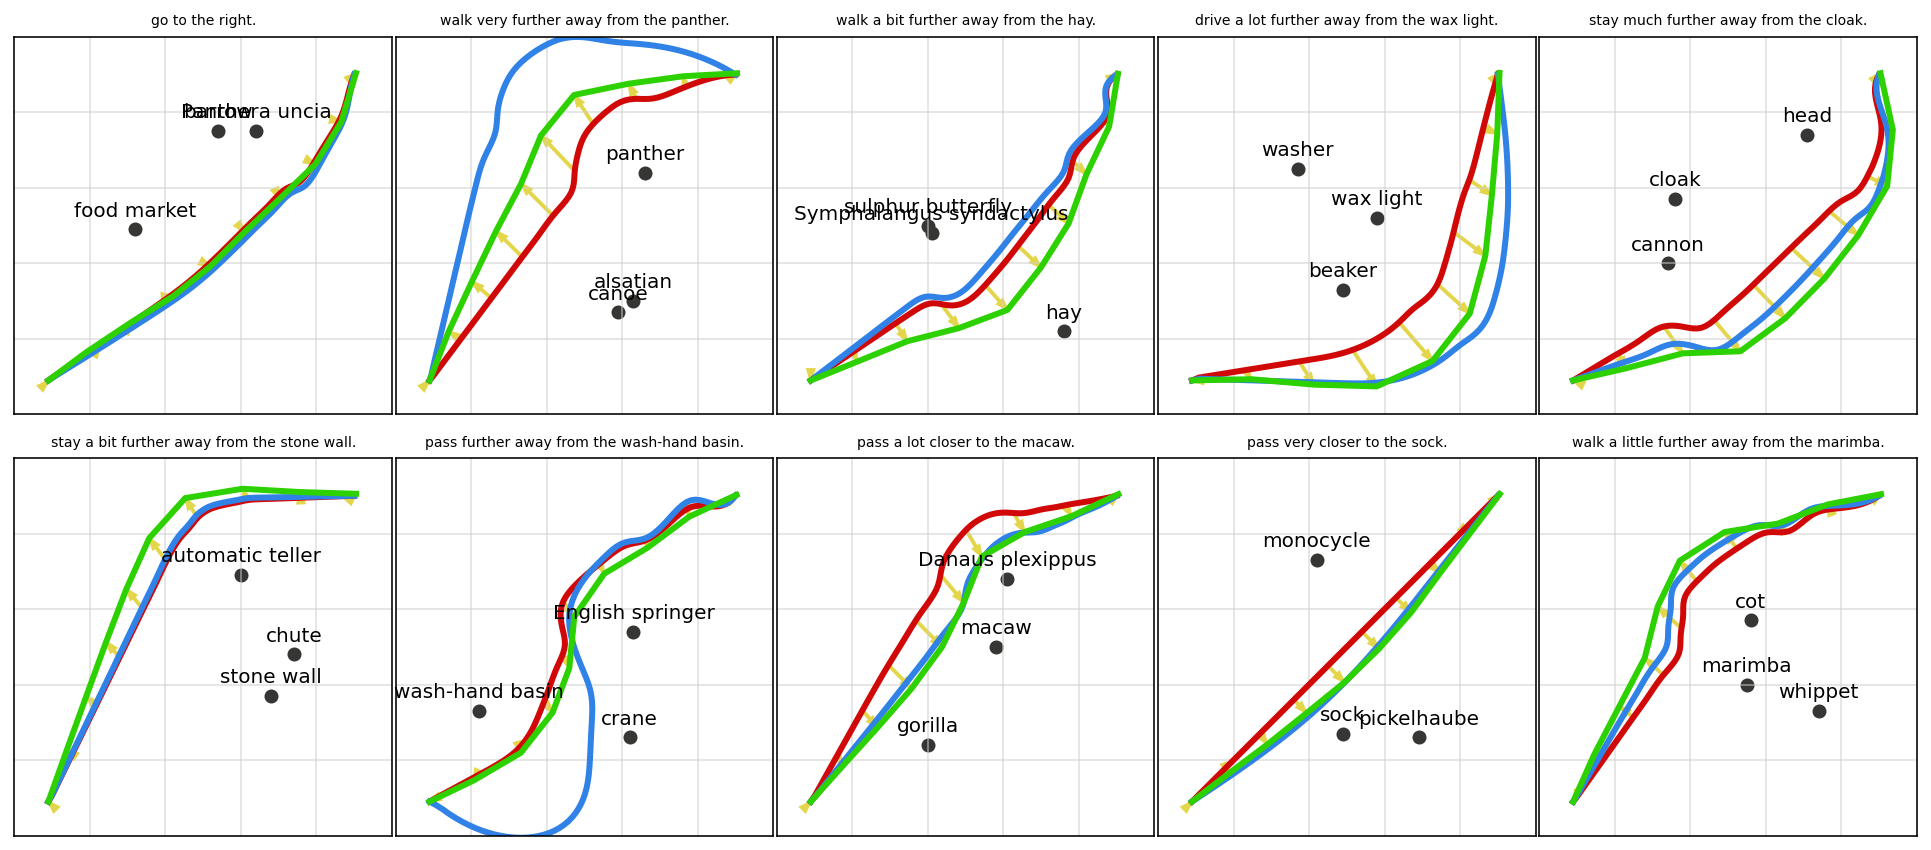

In [116]:
# errors =  1601
import matplotlib.pyplot as plt
from src.functions import *
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['lines.linewidth'] = 3
# plot_dist(np.transpose(y_t[:,:,:2],[0,2,1]))
# plot_dist(pred_t)

# (104, 72, 219)
show_data(data_array, pred = pred_d[indices],obj_txt=True, abs_pred=True,fig_mult=3, n_col=5)#, file = "/home/tum/data/img_array_Cartesian.png")

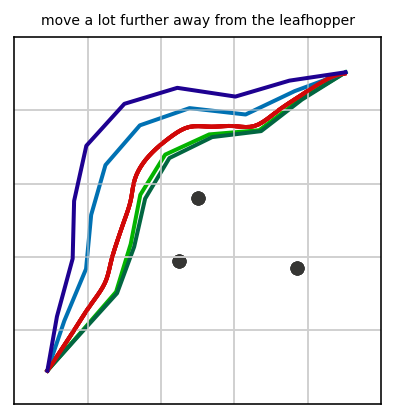

In [136]:
mpl.rcParams['lines.linewidth'] = 2

def apply_interactions(model, d,texts, mr, colors):
    data_new  = []
    for t in texts:
        data_new.append({"input_traj":d["input_traj"],"output_traj":d["output_traj"],"text":t,"obj_names":d["obj_names"],
                        "obj_poses":d["obj_poses"]})

    x, y = mr.prepare_data(data_new)
    
    dataset = tf.data.Dataset.from_tensor_slices((prepare_x(x),
                                                list_to_wp_seq(y),
                                                x[:,embedding_indices])).batch(x.shape[0])
    g = generator(dataset,stop=True,augment=False)
    x_t, y_t = next(g)
    pred = generate(model ,x_t).numpy()


    # 763, 615
    pred_t = np.transpose(pred[:,:,:2]+0.5,[0,2,1])
    pred_d = pred_t.reshape([pred_t.shape[0],pred_t.shape[2]*2])
    
    
    show_data([data_new[0]], show=False, arrows = False, obj_txt = False, show_label=False,pred = pred_d[0:1],pred_c=colors[0], new_fig=True, abs_pred=True,fig_mult=3, n_col=5)
    for i in range(1,len(text)):

        # print(data_new.shape, pred_d[indices[i:i+1]].shape)
        show_data([data_new[i]] ,show=False, arrows = False, obj_txt = False, show_label=False, pred_c=colors[i],pred = pred_d[i:i+1], new_fig=False, abs_pred=True,fig_mult=3, n_col=5)
    plt.show()

index = 820 # 1099
# index = 1553
obj_name = "leafhopper"
text = ["move a bit closer to the "+obj_name, "move a lot closer to the "+obj_name, "move a bit further away from the "+obj_name, "move a lot further away from the "+obj_name]
d = np.array(data)[indices_test[index]]
apply_interactions(model,d, text, mr, colors = ["#03b300","#026641","#0071b3", "#1e0191"])

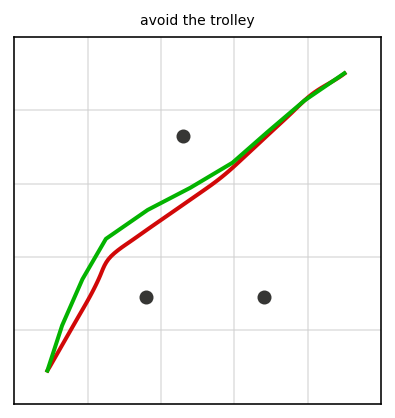

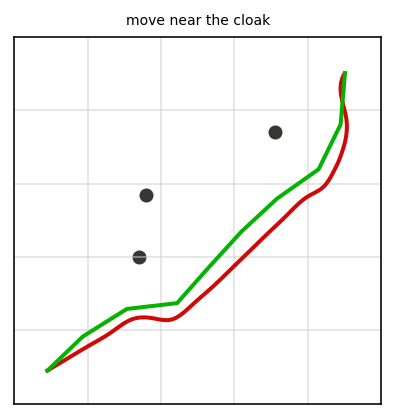

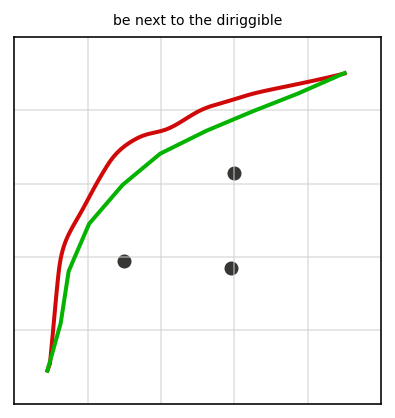

In [137]:
index = 786 # 1099

text = ["avoid the trolley"]
d = np.array(data)[indices_test[index]]
apply_interactions(model,d, text, mr, colors = ["#03b300","#026641","#0071b3", "#1e0191"])

index = 501
text = ["move near the cloak"]
d = np.array(data)[indices_test[index]]
apply_interactions(model,d, text, mr, colors = ["#03b300","#026641","#0071b3", "#1e0191"])


index = 1119
text = ["be next to the diriggible"]
d = np.array(data)[indices_test[index]]
apply_interactions(model,d, text, mr, colors = ["#03b300","#026641","#0071b3", "#1e0191"])


## Fully connected

In [ ]:
model_path = "./models/"
model_name = "fullyconn_bs128_atvtanh_ls5_dp0.1_nh512.h5"
model = tf.keras.models.load_model(model_path+model_name)
result = model.evaluate(X_test, y_test)
print(result)

In [133]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              817152    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)              

### trash code

In [ ]:
import numpy as np
from transformers import AutoTokenizer, pipeline, TFDistilBertModel, DistilBertTokenizer
from scipy.spatial.distance import cosine


def load_bert(name,model_name):
    model = model_name.from_pretrained(name)
    tokenizer = AutoTokenizer.from_pretrained(name, padding='max_length', max_length=48, do_lower_case=True, pad_to_max_length=True)
    # tokenizer = DistilBertTokenizer.from_pretrained(name, max_length=48, do_lower_case=True, pad_to_max_length=True)
    
    pipe = pipeline('feature-extraction', model=model, tokenizer=tokenizer)
    return pipe,model,tokenizer


pipe_bert,model_bert,tokenizer_bert = load_bert('distilbert-base-uncased',TFDistilBertModel)


In [ ]:
distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFDistilBertModel.from_pretrained(distil_bert, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
cls_token = embedding_layer[:,0,:]

l = tf.keras.layers.BatchNormalization()(cls_token)


l = tf.keras.layers.Dense(192, activation='relu')(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Dense(6, activation='softmax')(l)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = l)

for layer in model.layers[:3]:
  layer.trainable = False

In [ ]:
texts = [d["text"] for d in data[:768]]
z=['The dog','The ship sank in the Atlantic Ocean']

In [ ]:
fb = pipe_bert(z,pad_to_max_length=True)
fb = np.squeeze(fb)

# t = tokenizer_bert(z,pad_to_max_length=True)
print(t)
np.array(fb[0]).shape
# nlp = pipeline('feature-extraction',max_lenght=40)
# fnlp = nlp(z,pad_to_max_length=True)

Error: Session cannot generate requests

In [38]:
f = pipe_bert(texts)
f = np.squeeze(f)
print(f.shape)

(768,)


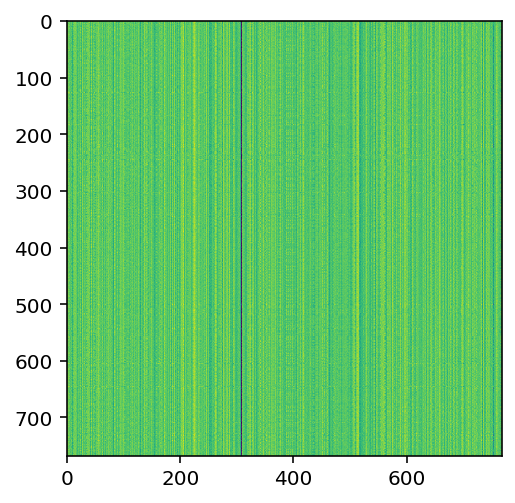

In [45]:
plt.imshow(fts, interpolation='nearest')
plt.show()

In [ ]:

def transformer_embedding(name,inp,model_name):


    model = model_name.from_pretrained(name)
    tokenizer = AutoTokenizer.from_pretrained(name)
    pipe = pipeline('feature-extraction', model=model, 
                tokenizer=tokenizer)
    features = pipe(inp)
    features = np.squeeze(features)
    return features

# def compute_bert_embeding(name,inp,model_name):


z=['The brown fox jumped over the dog','The ship sank in the Atlantic Ocean']
embedding_features1=transformer_embedding('distilbert-base-uncased',z[0],TFDistilBertModel)
embedding_features2=transformer_embedding('distilbert-base-uncased',z[1],TFDistilBertModel)
distance=1-cosine(embedding_features1[0],embedding_features2[0])
print(distance)

In [ ]:
ft = mr.compute_bert_embeding(data[:768])

In [48]:
np.sum((X[1,:768]-X[2,:768])**2)

8.57196567288067

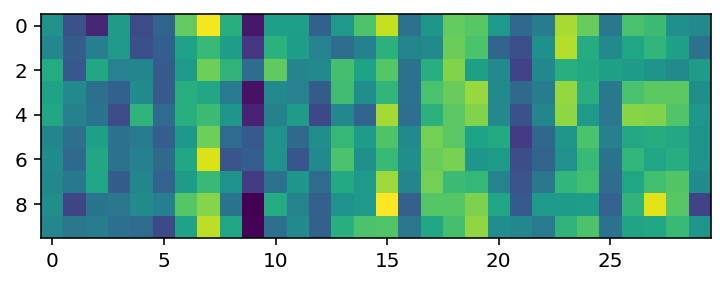

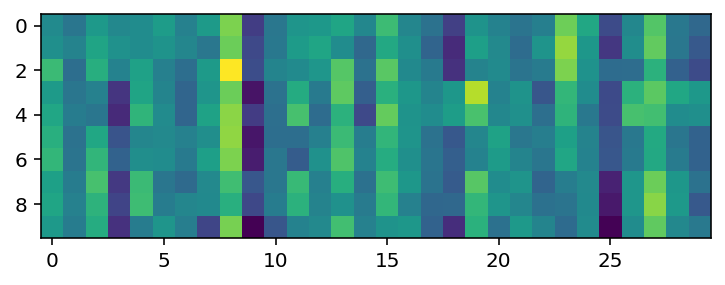

In [50]:
plt.imshow(X[:10,:30], interpolation='nearest')
plt.show()
plt.imshow(fts[:10,:30], interpolation='nearest')
plt.show()

In [32]:
# tf.keras.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
model

In [29]:
enc_layer=model.get_layer('encoder_1')
dec_layer=model.get_layer('decoder_1')

# enc_layer.build(input_shape=(None,None,2))
weights = enc_layer.get_weights()
# weights
enc_layer.layers

AttributeError: 'Encoder' object has no attribute 'layers'

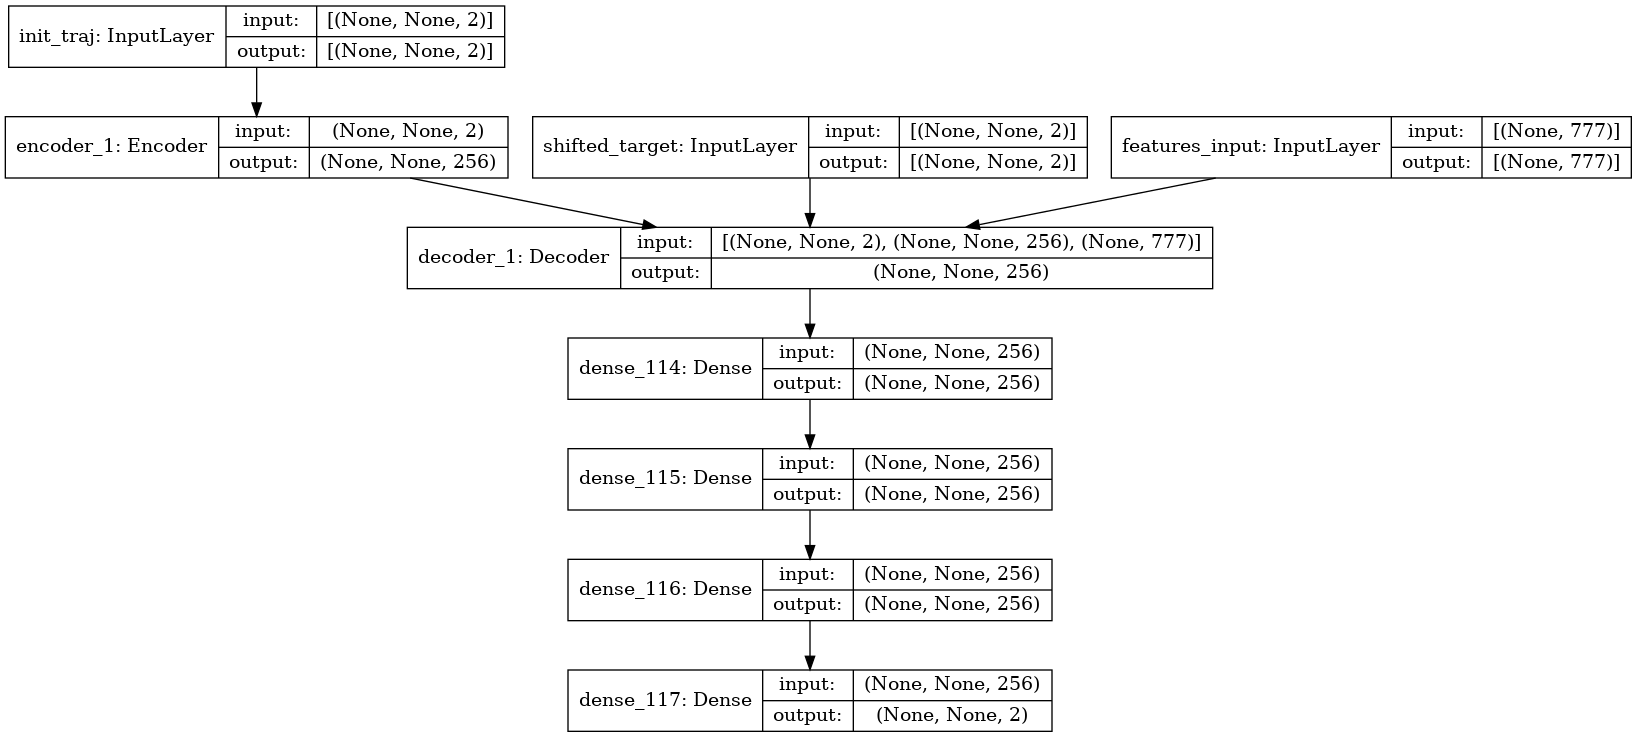

In [28]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, expand_nested=True, show_shapes=True)